Installing pickle-compat so we're able to read data serialized using python2 in python3

In [ ]:
!pip install pickle-compat

Importing and running pickle_compat

In [2]:
import pickle_compat

pickle_compat.patch()

Importing all necessary libraries

In [3]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import ZeroPadding2D
##from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

Loading the dataset

In [4]:
Xd = pickle.load(open(r"C:\Users\Sanjna\Desktop\5th sem\mini project\RML2016.10a_dict.pkl",'rb'))
snrs,mods = list(map((lambda j: sorted(list(set(map((lambda x: x[j]), Xd.keys() ) ) ) ) ), [1,0]))
X = []  
lbl = []
for mod in mods:
    for snr in snrs[10:]:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
            
X = np.vstack(X)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


Visualizing the classes

In [5]:
#dataset
for key, value in Xd.items():
    print (key)

('QPSK', 2)
('PAM4', 8)
('AM-DSB', -4)
('GFSK', 6)
('QAM64', 8)
('AM-SSB', 12)
('8PSK', 8)
('8PSK', 12)
('QAM64', -6)
('QAM16', 2)
('QAM16', -20)
('PAM4', -6)
('WBFM', -18)
('AM-DSB', 16)
('CPFSK', 10)
('WBFM', 6)
('BPSK', 4)
('BPSK', -2)
('QPSK', -20)
('CPFSK', -8)
('AM-SSB', 6)
('QAM64', -20)
('QAM16', 12)
('GFSK', -20)
('AM-SSB', -12)
('CPFSK', 0)
('AM-DSB', 6)
('BPSK', -16)
('QPSK', -6)
('8PSK', -12)
('CPFSK', -18)
('BPSK', -10)
('QPSK', 8)
('PAM4', 14)
('AM-DSB', -10)
('GFSK', 12)
('QAM64', 2)
('WBFM', -4)
('AM-SSB', -18)
('QAM64', -4)
('GFSK', -4)
('AM-DSB', 8)
('PAM4', -16)
('QPSK', -16)
('BPSK', 16)
('8PSK', -8)
('CPFSK', 16)
('WBFM', 0)
('QPSK', 6)
('BPSK', 14)
('AM-DSB', -8)
('GFSK', -10)
('CPFSK', -2)
('AM-SSB', 8)
('GFSK', 18)
('QAM16', 6)
('QAM16', -16)
('QAM64', 18)
('AM-SSB', -2)
('CPFSK', 6)
('BPSK', 0)
('BPSK', -6)
('8PSK', -14)
('CPFSK', -12)
('AM-SSB', 2)
('WBFM', 10)
('AM-DSB', -12)
('PAM4', 4)
('GFSK', 10)
('QAM16', -6)
('QAM64', 4)
('PAM4', -20)
('8PSK', 10)
('AM-

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot (list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot (list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [7]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(55000, 2, 128) [2, 128]


In [8]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(256, 1, 3, activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(256, 1, 3, activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 256)         65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 256)         0

In [9]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [11]:

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(tf.expand_dims(X_train, axis=-1),
     Y_train,
     batch_size=batch_size,
     epochs=nb_epoch,
     #show_accuracy=False,
     verbose=2,
     validation_data=(X_test, Y_test),
     callbacks = [
         keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='auto'),
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')
     ])
# we re-load the best weights once training is finished
#model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)
model.load_weights(filepath)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.09518, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 2.2586 - val_loss: 2.0952
Epoch 2/100

Epoch 00002: val_loss improved from 2.09518 to 1.95077, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 2.0781 - val_loss: 1.9508
Epoch 3/100

Epoch 00003: val_loss improved from 1.95077 to 1.62065, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 1.8559 - val_loss: 1.6206
Epoch 4/100

Epoch 00004: val_loss improved from 1.62065 to 1.43560, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 1.6326 - val_loss: 1.4356
Epoch 5/100

Epoch 00005: val_loss improved from 1.43560 to 1.32217, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 1.4977 - val_loss: 1.3222
Epoch 6/100

Epoch 00006: val_loss improved from 1.32217 to 1.26473, saving model to convmodrecnets_CNN2_0.5.wts.h5
54/54 - 3s - loss: 1.4153 - val_loss: 1.2647
Epoch 7/100

Epoch 00007: val_loss imp

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

0.978328287601471


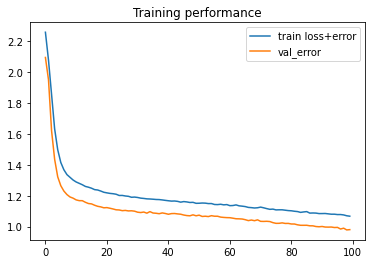

In [13]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [14]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

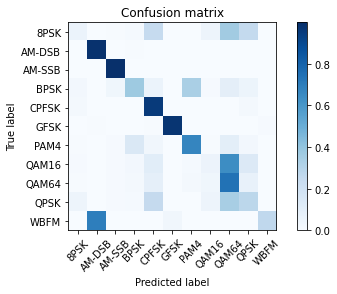

In [15]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.5538999264164827
Overall Accuracy:  0.617353421673625
Overall Accuracy:  0.6061477619989214
Overall Accuracy:  0.6004023408924652
Overall Accuracy:  0.5752502274795268
Overall Accuracy:  0.5653916211293261
Overall Accuracy:  0.5731506849315069
Overall Accuracy:  0.5650984682713348
Overall Accuracy:  0.5601380813953488
Overall Accuracy:  0.5625896700143472


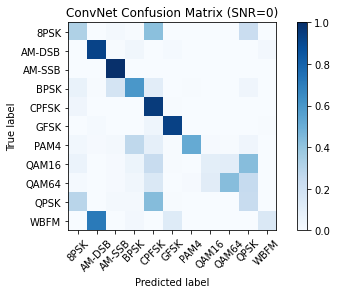

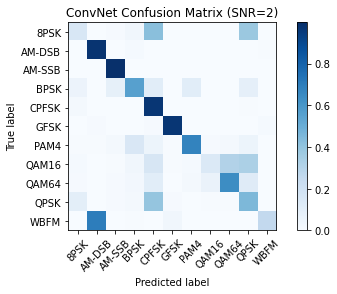

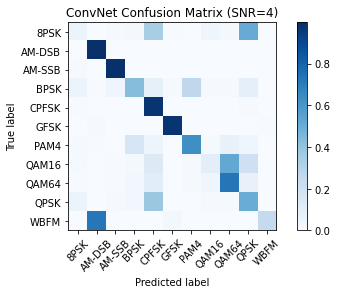

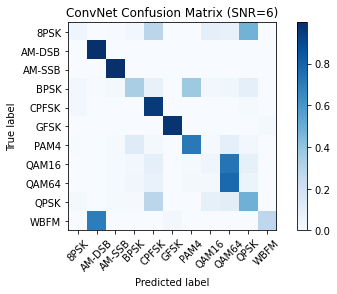

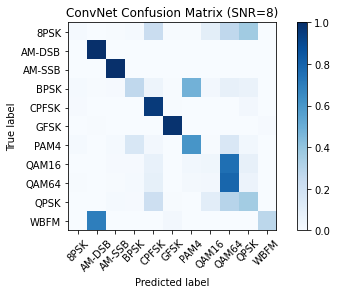

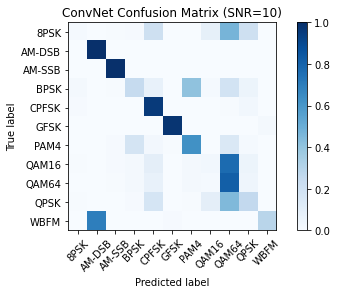

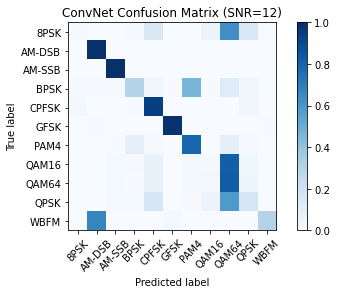

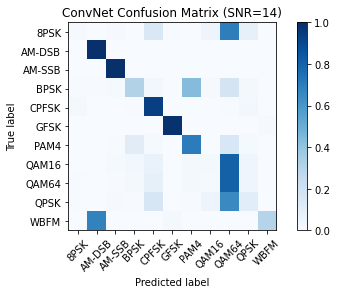

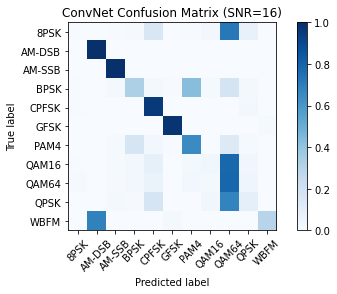

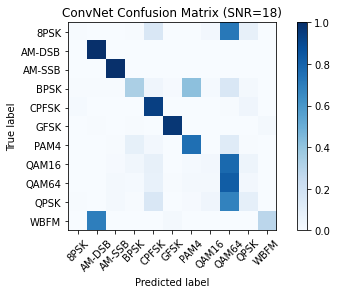

In [17]:
# Plot confusion matrix
acc = {}
for snr in snrs[10:]:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ('Overall Accuracy: ', cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [18]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.5538999264164827, 2: 0.617353421673625, 4: 0.6061477619989214, 6: 0.6004023408924652, 8: 0.5752502274795268, 10: 0.5653916211293261, 12: 0.5731506849315069, 14: 0.5650984682713348, 16: 0.5601380813953488, 18: 0.5625896700143472}
{0: 0.5538999264164827, 2: 0.617353421673625, 4: 0.6061477619989214, 6: 0.6004023408924652, 8: 0.5752502274795268, 10: 0.5653916211293261, 12: 0.5731506849315069, 14: 0.5650984682713348, 16: 0.5601380813953488, 18: 0.5625896700143472}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

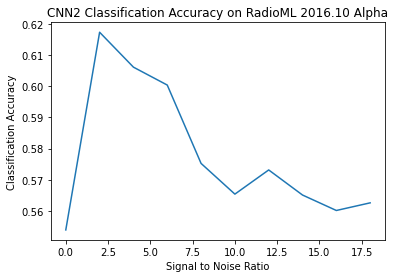

In [20]:
# Plot accuracy curve
plt.plot(snrs[10:], list(map(lambda x: acc[x], snrs[10:])))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")